In [1]:
import pickle
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam
from keras.models import Model
import keras.initializers as KI
from keras.layers import Dense, Dropout, Input, LeakyReLU
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load Data, Create Validation Split

In [2]:
train = pickle.load(open('../data/train_preprocessed.pkl','rb'))
test = pickle.load(open('../data/test_preprocessed.pkl','rb'))
labels = pickle.load(open('../data/labels_preprocessed.pkl','rb'))

train, val, labels, val_labels = train_test_split(train, labels, random_state=42,
                                                 test_size=0.2, shuffle=True)

## Define Constants

In [3]:
VOCABULARY_SIZE = 100000  #this is the maximum vocabulary size; hyperparameter
SEQUENCE_LENGTH = 150 #this is the length of each sequence being fed to the GRU/LSTM - hyperparameter
EMBEDDING_SIZE = 300 #this depends on the embedding values used; 300 is the Google matrix w2v size

EPOCHS = 50
BATCH_SIZE = 500

## Utility Functions

In [4]:
def GetMicroAccuracy(labels, predictions):
    _val_f1 = f1_score(labels, predictions, average='micro')
    _val_recall = recall_score(labels, predictions, average='micro')
    _val_precision = precision_score(labels, predictions, average='micro')
    print ("[Weighted] F1 Score: %f,  Precision: %f,  Recall: %f" % (_val_f1, _val_precision, _val_recall))

In [5]:
from keras import backend as K
#calculat the class weights:  2d array (# of classes (ROWS), 2 * (background and signal))
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

#custom loss function
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), 
                      axis=-1)
    return weighted_loss

## Tokenize Text Data (limited by VOCABULARY_SIZE)

In [6]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(train.doc_text.values) + list(val.doc_text.values))  #add TEST for prediction
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= VOCABULARY_SIZE}
list_tokenized_train = tokenizer.texts_to_sequences(train.doc_text.values)
list_tokenized_val = tokenizer.texts_to_sequences(val.doc_text.values)
#list_tokenized_test = tokenizer.texts_to_sequences(test.doc_text.values)

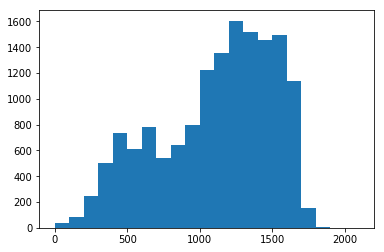

1112.424839228296


In [7]:
#to choose the appropriate maxlen, find what "most" of the sentences have in terms of words and get close to that
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,2200,100) )
plt.show()
print(np.mean(totalNumWords))

In [8]:
train_pad = pad_sequences(list_tokenized_train, maxlen=SEQUENCE_LENGTH)
val_pad = pad_sequences(list_tokenized_val, maxlen=SEQUENCE_LENGTH)
#test_pad = pad_sequences(list_tokenized_test, maxlen=SEQUENCE_LENGTH)

## Custom Word2Vec Embeddings

In [9]:
import logging
import gensim

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load Google's pre-trained Word2Vec model.
#w2v_model = gensim.models.KeyedVectors.load_word2vec_format('../data/vectors.kv', binary=False)  
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("c:/edx/competition/data/vectors.kv")
w2v_model = gensim.models.KeyedVectors.load(fname, mmap='r')

2019-02-18 21:58:14,064 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-02-18 21:58:14,064 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
2019-02-18 21:58:14,080 : INFO : loading Word2VecKeyedVectors object from c:/edx/competition/data/vectors.kv
2019-02-18 21:58:15,123 : INFO : loading vectors from c:/edx/competition/data/vectors.kv.vectors.npy with mmap=r
2019-02-18 21:58:15,123 : INFO : setting ignored attribute vectors_norm to None
2019-02-18 21:58:15,123 : INFO : loaded c:/edx/competition/data/vectors.kv


In [10]:
nb_words = min(VOCABULARY_SIZE, len(tokenizer.word_index)) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE))
missing_words = []
for word, i in tokenizer.word_index.items():
    if word in w2v_model.vocab:
        embedding_matrix[i] = w2v_model.word_vec(word)
    else:
        missing_words.append(word)

print('Total word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) != 0))
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Total word embeddings: 100000
Null word embeddings: 1


# <font color="Red">Keras </font> Model

In [11]:
#from importlib import reload
#reload(model_zoo)

In [12]:
class_wt = calculating_class_weights(labels.values)

from utils import model_zoo
#model = model_zoo.get_dropout_bi_gru(nb_words=nb_words, embedding_dim=EMBEDDING_SIZE,
#                         embedding_matrix=embedding_matrix, max_sequence_length=SEQUENCE_LENGTH,
#                         out_size=len(labels.columns), loss_fn=get_weighted_loss, class_weights=class_wt,
#                         val_data=val_pad, val_labels=val_labels)

model = model_zoo.get_kmax_text_cnn(nb_words=nb_words, 
    embedding_dim=EMBEDDING_SIZE, 
    embedding_matrix=embedding_matrix, 
    max_sequence_length=SEQUENCE_LENGTH, 
    out_size=len(labels.columns))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 300)     30000300    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 150, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 150, 180)     54180       spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_2 (

In [13]:
#from sklearn.utils import class_weight
#class_wt = class_weight.compute_sample_weight('balanced', labels.values)
history = model.fit(train_pad, labels.values, epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, verbose=1, validation_data=(val_pad, val_labels))

Train on 14928 samples, validate on 3732 samples
Epoch 1/50
14928/14928 [==============================] - 16s 1ms/step - loss: 0.7957 - acc: 0.8296 - f1: 0.2196 - val_loss: 0.3432 - val_acc: 0.8747 - val_f1: 0.2782
Epoch 2/50
14928/14928 [==============================] - 13s 868us/step - loss: 0.4017 - acc: 0.8602 - f1: 0.2513 - val_loss: 0.2886 - val_acc: 0.8992 - val_f1: 0.2665
Epoch 3/50
14928/14928 [==============================] - 13s 870us/step - loss: 0.3451 - acc: 0.8807 - f1: 0.2689 - val_loss: 0.2815 - val_acc: 0.9000 - val_f1: 0.2766
Epoch 4/50
14928/14928 [==============================] - 13s 870us/step - loss: 0.3206 - acc: 0.8879 - f1: 0.2879 - val_loss: 0.2751 - val_acc: 0.9010 - val_f1: 0.2945
Epoch 5/50
14928/14928 [==============================] - 13s 869us/step - loss: 0.3060 - acc: 0.8922 - f1: 0.2941 - val_loss: 0.2725 - val_acc: 0.9026 - val_f1: 0.3211
Epoch 6/50
14928/14928 [==============================] - 13s 869us/step - loss: 0.2956 - acc: 0.8951 - f1: 

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(val_pad).round().astype(np.uint8)
GetMicroAccuracy(val_labels.values, predictions)

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','f1'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# show the F1 vs val_f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()